<a href="https://colab.research.google.com/github/prasidha1/fellowship_twitter/blob/master/fellowship_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the modules required for accessing the folder in google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# importing the modules used
from fastai.text import *
from sklearn.model_selection import train_test_split
%matplotlib inline 

In [3]:
# reading the csv file
# Will be including a mixture of data type in training using random function
df = pd.read_csv('/content/gdrive/My Drive/Project_folder/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
3455,568429641699954688,neutral,1.0,NaN,NaN,United,NaN,iamtedking,NaN,0,@united any news?,NaN,2015-02-19 07:19:22 -0800,NaN,Eastern Time (US & Canada)
13157,569925940224139264,neutral,1.0,NaN,NaN,American,NaN,Vaomatua,NaN,0,@AmericanAir #AmericanView\nThe view of Oregon...,"[30.441566, -84.281745]",2015-02-23 10:25:07 -0800,NaN,Arizona
92,569911816937033728,negative,1.0,Cancelled Flight,1.0000,Virgin America,NaN,AlisonK33774854,NaN,0,@VirginAmerica I like the TV and interesting v...,NaN,2015-02-23 09:29:00 -0800,NaN,NaN
11252,568289529561518080,negative,1.0,Customer Service Issue,0.6443,US Airways,NaN,faye_nds,NaN,0,@USAirways flying from Manchester internationa...,NaN,2015-02-18 22:02:36 -0800,"Merano, Italy",London
5793,568591059602829314,positive,1.0,NaN,NaN,Southwest,NaN,iknowmatt2,NaN,0,@SouthwestAir a nice trip back home after a lo...,NaN,2015-02-19 18:00:47 -0800,~~ Rhode Island ~~,Eastern Time (US & Canada)


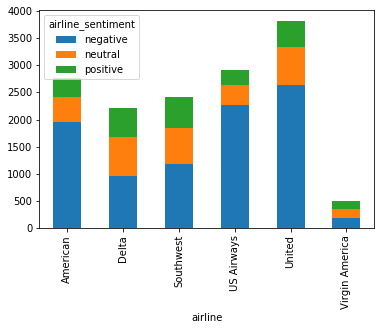

In [4]:
#visualizing the percentage of different sentiments present and that associated with different airlines.
df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True)

In [0]:
#preprocessing the data
test_percentage = 0.1
df.sort_index(inplace=True)
cutoff = int(test_percentage * df.shape[0])
df[['airline_sentiment', 'text']][:cutoff].to_csv('Tweets_filtered_test.csv', index=False, encoding='utf-8')
df[['airline_sentiment', 'text']][cutoff:].to_csv('Tweets_filtered_train.csv', index=False, encoding='utf-8')
df[['text']][cutoff:].to_csv('Tweets_text_only_train.csv', index=False, encoding='utf-8')

In [6]:
#Tokonization
#We read in the data and add new words to our dictionary, as well as create a representation of words using numbers.
data = TextClasDataBunch.from_csv('.', 'Tweets_filtered_train.csv')
data.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
"xxbos @usairways 4 segments , 4 / 4 delayed . xxmaj gnv > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup gnv . xxmaj my year off from flying with you guys was the way to go .",negative
"xxbos @southwestair i had to travel to xxmaj savannah , xxup xxunk , once again , on an airline i do n't "" xxmaj luv "" . xxmaj when r u going to fly me to xxmaj savannah ? xxmaj pl xxrep 4 e ase xxrep 4 !",neutral
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive


In [7]:
#new words added to our dictionary list
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [8]:
bs = 24
seed = 333
data_lm = (TextList.from_csv('.', 'Tweets_text_only_train.csv')
            .random_split_by_pct(0.1, seed = seed)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('/content/gdrive/My Drive/Project_folder/data_lm_export.pkl')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [9]:
data_lm.show_batch()

idx,text
0,xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow xxbos @united xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you xxbos @united it was delivered ! xxmaj thank you for making sure it arrived at my xxunk ! xxbos @united - rebooked
1,"good to know . xxbos @united okay . xxmaj thanks . xxbos @united xxmaj conference xxunk in 3 hours . xxmaj up all night due to delays and still waiting to talk to someone about lost luggage . xxbos @united xxmaj seat xxup xxunk , xxmaj flight xxup xxunk xxbos @united is it on a flight now ? xxmaj thanks for reply . xxbos @united is xxunk and i am"
2,"and the delay turns into a xxmaj cancelled xxmaj flight ... xxbos @united xxup ua xxunk delayed again - i get charged $ 600 if xxmaj late xxmaj flight by you - you say "" oh well "" xxbos @united we are trying to go as far away from king'scollegelondon as possible for # charity today . xxmaj would you help us ? # jailbreak # xxup rag xxbos @united"
3,"back to 1st class . xxmaj xxunk ? xxmaj really ? @united : xxunk xxmaj your xxunk is xxunk xxbos @united xxmaj thanks xxmaj yup i 'm all set . xxmaj it happens . xxup slc ground staff were prompt , helpful and courteous . xxbos xxmaj there were plenty of empty seats in coach "" @united : xxmaj your xxunk is understood . xxmaj crew members traveling for duty"
4,"when i boarded . xxbos “ @united : xxunk xxmaj sorry to hear about your flight . xxmaj do you need help reflight xxmaj booking xxmaj problems ? ” \n \n 👎 xxbos @united now we are trying to get to xxmaj san xxmaj juan from xxmaj chicago o'hare . xxmaj having lots of problems . xxmaj may get a standby flight . xxbos @united xxmaj alright , thank"


In [10]:
# Applying the ULMFit model for training the data.
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [11]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.108196,3.806271,0.266161,00:13


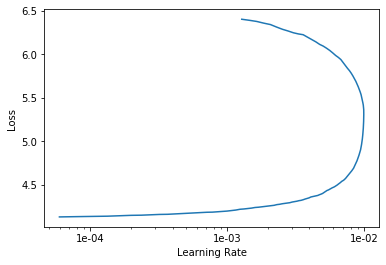

In [12]:
learn.recorder.plot()

In [13]:
#unfreezing
learn.save('fit_head')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.719341,3.668260,0.286012,00:18
1,3.586594,3.580627,0.296964,00:19
2,3.414943,3.525367,0.303899,00:18
3,3.131040,3.524671,0.306696,00:18
4,2.777863,3.597751,0.299940,00:18
5,2.407531,3.704844,0.296577,00:18
6,2.081064,3.838562,0.293452,00:18
7,1.825173,3.945090,0.291815,00:18
8,1.683465,3.997092,0.290655,00:18
9,1.610022,4.023081,0.290536,00:18


In [14]:
#saving the model, encoding and testing the trained model
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')
data_clas = (TextList.from_csv('.', 'Tweets_filtered_train.csv', cols = 'text')               
             .random_split_by_pct(0.1, seed = seed)
             .label_from_df(cols=0)
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')
data_clas.show_batch()


/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to xxunk it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
xxbos @usairways xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup xxunk just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help ?,negative
"xxbos @united ( 2 / 2 ) xxmaj it xxunk that if ca n't confirm xxunk at time of xxmaj flight xxmaj booking xxmaj problems , i should assume that it may never clear . xxmaj did n't used to be that way",negative
xxbos @united xxmaj missed xxup xxunk flight due to ur xxmaj cancelled xxmaj flightlation . xxmaj xxunk supervisor disgusting . xxmaj now day xxmaj late xxmaj flight . xxmaj no apology or upgrade offer to xxup lhr from xxup ord ? ? ?,negative


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


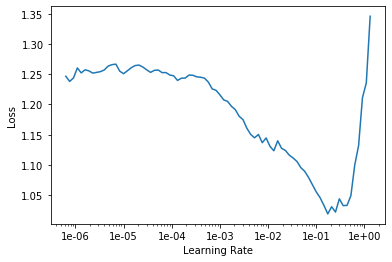

In [15]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.662519,0.535471,0.788155,00:09


In [17]:
# learn.load('first)
learn.save('first')
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.635639,0.510062,0.791951,00:12


In [18]:
# learn.load('second')
learn.save('second')
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.541804,0.459529,0.807897,00:19


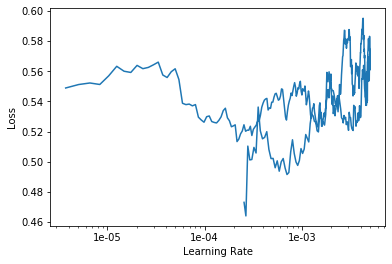

In [19]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.452607,0.447612,0.815490,00:23
1,0.414893,0.473461,0.804860,00:23
2,0.365991,0.456449,0.820805,00:24


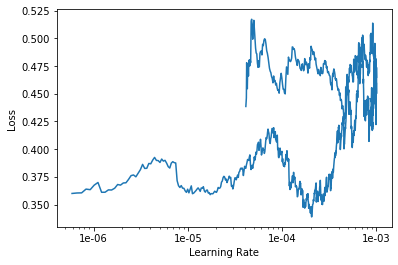

In [20]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.recorder.plot(skip_end=15)

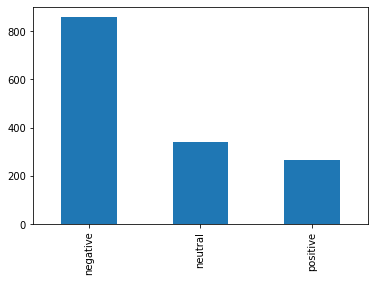

In [21]:
#Evaluate Performance on Test Set
test_df = pd.read_csv("Tweets_filtered_test.csv", encoding="utf-8")
test_df['airline_sentiment'].value_counts().plot(kind='bar')

In [22]:
#checking the  predicted sentiment vs the actual sentiment
test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(test_df['airline_sentiment'], test_df['pred_sentiment']))
test_df[:20]

Test Accuracy:  0.8060109289617486


,airline_sentiment,text,pred_sentiment
0,neutral,@VirginAmerica What @dhepburn said.,neutral
1,positive,@VirginAmerica plus you've added commercials t...,negative
2,neutral,@VirginAmerica I didn't today... Must mean I n...,neutral
3,negative,@VirginAmerica it's really aggressive to blast...,negative
4,negative,@VirginAmerica and it's a really big bad thing...,negative
5,negative,@VirginAmerica seriously would pay $30 a fligh...,negative
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",negative
7,neutral,@VirginAmerica Really missed a prime opportuni...,negative
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",neutral
9,positive,"@VirginAmerica it was amazing, and arrived an ...",positive


In [23]:
#checking for the data having descripancies in actual sentiment and predicted sentiment
test_df.loc[(test_df['airline_sentiment'] == 'positive') & (test_df['pred_sentiment'] == 'negative')]

,airline_sentiment,text,pred_sentiment
1,positive,@VirginAmerica plus you've added commercials t...,negative
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",negative
19,positive,@VirginAmerica you know what would be amazingl...,negative
64,positive,@VirginAmerica @ladygaga @carrieunderwood lov...,negative
81,positive,@VirginAmerica I've applied more then once to ...,negative
109,positive,"@VirginAmerica has getaway deals through May, ...",negative
111,positive,"@VirginAmerica has getaway deals through May, ...",negative
114,positive,@VirginAmerica come back to #PHL already. We n...,negative
203,positive,@VirginAmerica cool picture of another VirginA...,negative
273,positive,@VirginAmerica cutest salt and pepper shaker e...,negative


In [24]:
test_df.loc[(test_df['airline_sentiment'] == 'neutral') & (test_df['pred_sentiment'] == 'negative')]

,airline_sentiment,text,pred_sentiment
7,neutral,@VirginAmerica Really missed a prime opportuni...,negative
27,neutral,@VirginAmerica do you miss me? Don't worry we'...,negative
43,neutral,@VirginAmerica I have an unused ticket but mov...,negative
50,neutral,@VirginAmerica Is flight 769 on it's way? Was ...,negative
65,neutral,@VirginAmerica Flight 0736 DAL to DCA 2/24 2:1...,negative
...,...,...,...
1342,neutral,@united yes please. Going to drive the 6 hours.,negative
1348,neutral,@united the child is two years old,negative
1370,neutral,@united you'll be hearing from me for sure.,negative
1398,neutral,@united UA flight 1247. SFO to LAX took my car...,negative


In [25]:
test_df.loc[(test_df['airline_sentiment'] == 'neutral') & (test_df['pred_sentiment'] == 'positive')]

,airline_sentiment,text,pred_sentiment
29,neutral,@VirginAmerica LAX to EWR - Middle seat on a r...,positive
42,neutral,@VirginAmerica plz help me win my bid upgrade ...,positive
49,neutral,@VirginAmerica @ladygaga @carrieunderwood All ...,positive
62,neutral,@VirginAmerica @ladygaga @carrieunderwood all ...,positive
76,neutral,@VirginAmerica Or watch some of the best stude...,positive
278,neutral,👍👍✈️✈️💗 When are you guys going to start flyin...,positive
312,neutral,@VirginAmerica brought it all the way across t...,positive
315,neutral,@VirginAmerica are you ready!? Let's say it to...,positive
325,neutral,@VirginAmerica momma I made it! 😁😁😁,positive
328,neutral,@VirginAmerica @shrinerack Seattle bound. Wife...,positive
